# Computing with Dask

## Dask Arrays

A dask array looks and feels a lot like a numpy array.
However, a dask array doesn't directly hold any data.
Instead, it symbolically represents the computations needed to generate the data.
Nothing is actually computed until the actual numerical values are needed.
This mode of operation is called "lazy"; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

If we want to create a numpy array of all ones, we do it like this:

In [1]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

This array contains exactly 32 MB of data:

In [2]:
ones_np.nbytes / 1e6

32.0

Now let's create the same array using dask's array interface.

In [3]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

The dask array representation reveals the concept of "chunks". "Chunks" describes how the array is split into sub-arrays. We did not specify any chunks, so Dask just used one single chunk for the array. This is not much different from a numpy array at this point.

### Specifying Chunks

However, we could have split up the array into many chunks.

![Dask Arrays](http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg)
_source: [Dask Array Documentation](http://dask.pydata.org/en/latest/array-overview.html)_

There are [several ways to specify chunks](http://dask.pydata.org/en/latest/array-creation.html#chunks).
In this lecture, we will use a block shape.

In [4]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Notice that we just see a symbolic represetnation of the array, including its shape, dtype, and chunksize.
No data has been generated yet.
When we call `.compute()` on a dask array, the computation is trigger and the dask array becomes a numpy array.

In [5]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In order to understand what happened when we called `.compute()`, we can visualize the dask _graph_, the symbolic operations that make up the array

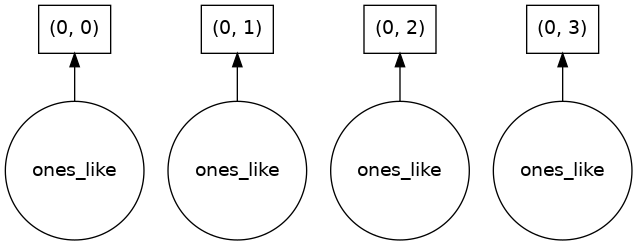

In [6]:
ones.visualize()

Our array has four chunks. To generate it, dask calls `np.ones` four times and then concatenates this together into one array.

Rather than immediately loading a dask array (which puts all the data into RAM), it is more common to want to reduce the data somehow. For example

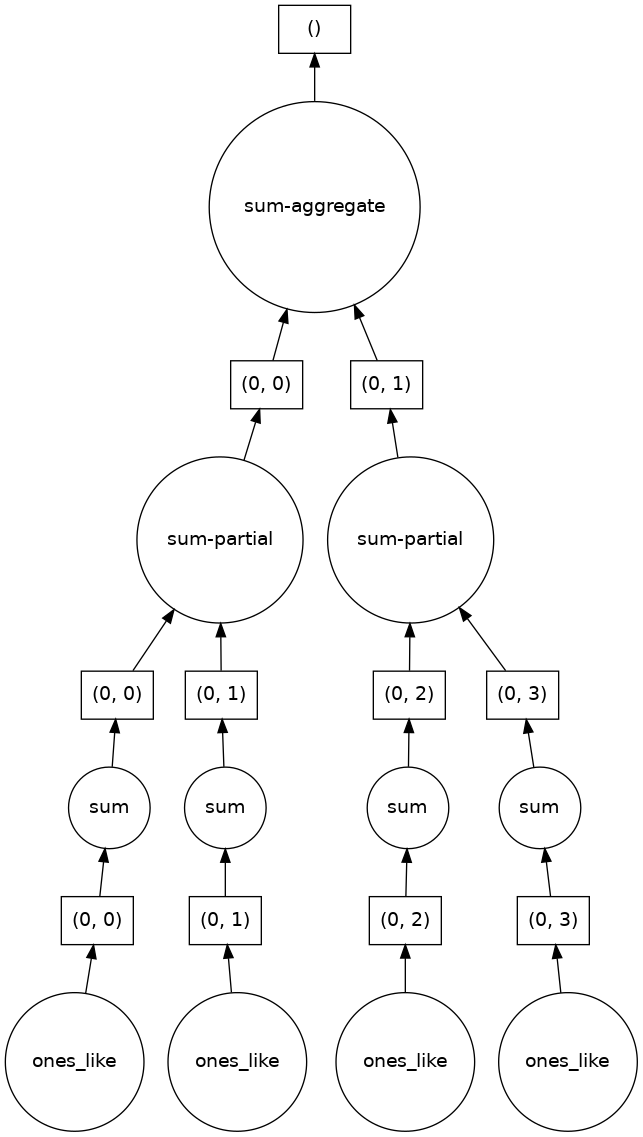

In [7]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Here we see dask's strategy for finding the sum. This simple example illustrates the beauty of dask: it automatically designs an algorithm appropriate for custom operations with big data. 

If we make our operation more complex, the graph gets more complex.

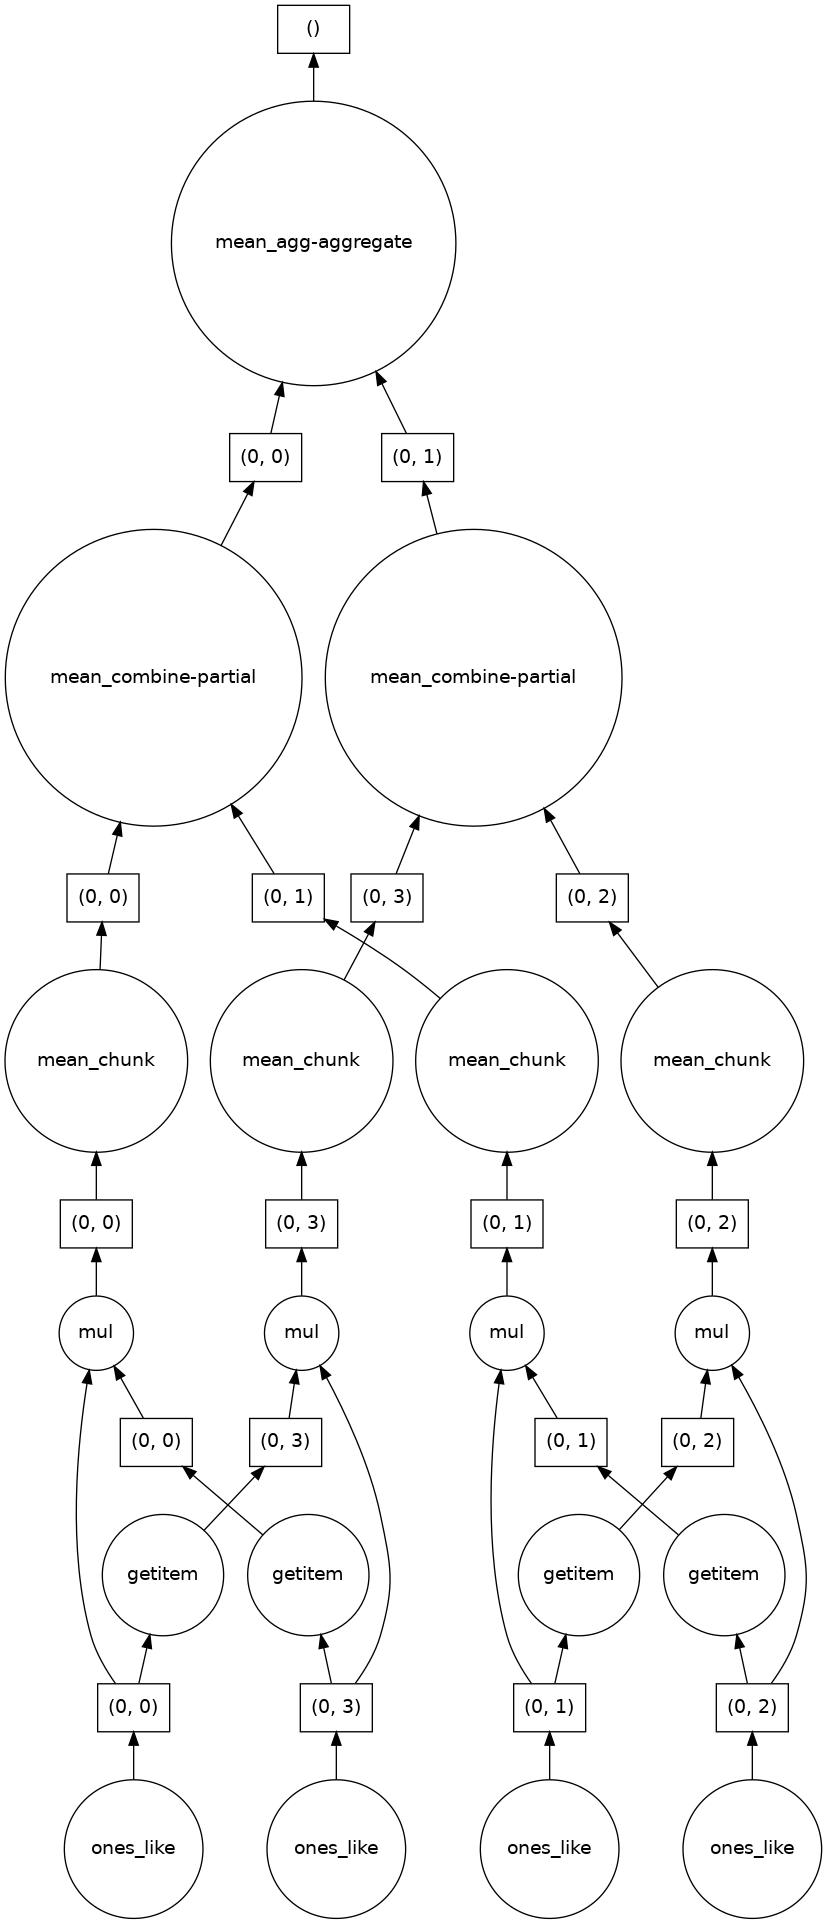

In [8]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

### A Bigger Calculation

The examples above were toy examples; the data (32 MB) is nowhere nearly big enough to warrant the use of dask.

We can make it a lot bigger!

In [9]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones_like, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [10]:
big_ones.nbytes / 1e6

6400.0

This dataset is 3.2 GB, rather MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, dask has no problem working on it.

_Do not try to `.visualize()` this array!_

When doing a big calculation, dask also has some tools to help us understand what is happening under the hood

In [11]:
from dask.diagnostics import ProgressBar

big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

[########################################] | 100% Completed |  2.4s


1.0

### Reduction 

All the usual numpy methods work on dask arrays.
You can also apply numpy function directly to a dask array, and it will stay lazy.

In [12]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=0)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

Plotting also triggers computation, since we need the actual values

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

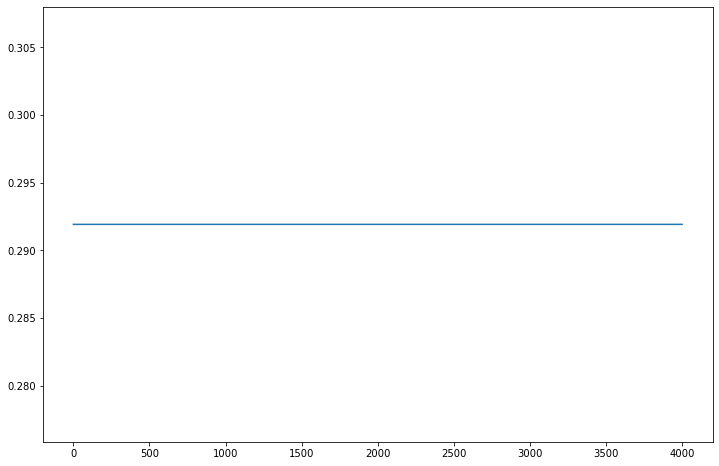

In [14]:
plt.plot(big_ones_reduce)

## Distributed Clusters

Once we are ready to make a bigger calculation with dask, we can use a Dask [Distributed](http://distributed.dask.org/en/stable/) cluster.

```{warning}
A common mistake is to move to distributed mode too soon.
For smaller data, distributed will actually be _much slower_ than the default multi-threaded scheduler or **not using Dask at all**.
You should only use distributed when your data is much larger than what your computer can handle in memory.
```

### Local Cluster

A local cluster uses all the CPU cores of the machine it is running on.
For our cloud-based Jupyterlab environments, that is just 2 cores--not very much.
However, it's good to know about.

In [15]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/rabernat/proxy/8787/status,
Dashboard: /user/rabernat/proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36005,Workers: 2
Dashboard: /user/rabernat/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://10.8.2.9:33951,Total threads: 1
Dashboard: /user/rabernat/proxy/38391/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:46605,


Note that the "Dashboard" link will open a new page where you can monitor a computation's progress.

In [16]:
big_calc.compute()

1.0

Here is another bigger calculation.

In [17]:
random_values = da.random.normal(size=(2e8,), chunks=(1e6,))
hist, bins = da.histogram(random_values, bins=100, range=[-5, 5]) 
hist

dask.array<sum-aggregate, shape=(100,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>

In [18]:
# actually trigger the computation
hist_c = hist.compute()

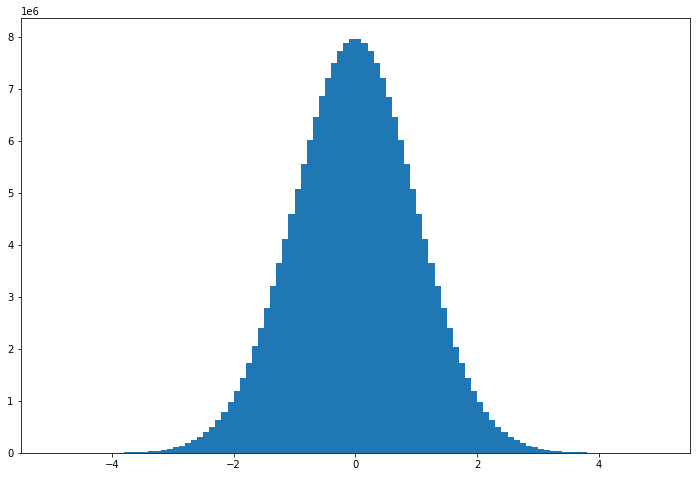

In [19]:
# plot results
x = 0.5 * (bins[1:] + bins[:-1])
width = np.diff(bins)
plt.bar(x, hist_c, width);

### Dask Gateway - A Cluster in the Cloud

Pangeo Cloud makes it possible to launch a much larger cluster using many virtual machines in the cloud.
This is beyond the scope of our class, but you can read more about it in the [Pangeo Cloud docs](https://pangeo.io/cloud.html#dask)

## Dask + XArray

Xarray can automatically wrap its data in dask arrays.
This capability turns xarray into an extremely powerful tool for Big Data earth science

To see this in action, we will open a dataset from the [Pangeo Cloud Data Catalog](https://catalog.pangeo.io/) - the Copernicus [Sea Surface Height](browse/master/ocean/sea_surface_height/) dataset.

In [20]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["sea_surface_height"].to_dask()
ds

<xarray.Dataset>
Dimensions:    (time: 8901, latitude: 720, longitude: 1440, nv: 2)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes: (12/43)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

Note that the values are not displayed, since that would trigger computation.

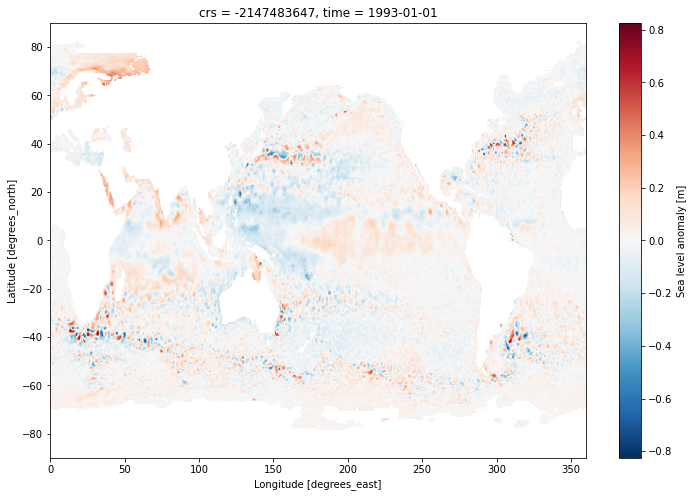

In [21]:
ds.sla[0].plot()

In [ ]:
# the computationally intensive step
sla_timeseries = ds.sla.mean(dim=('latitude', 'longitude')).load()

In [ ]:
sla_timeseries.plot(label='full data')
sla_timeseries.rolling(time=365, center=True).mean().plot(label='rolling annual mean')
plt.ylabel('Sea Level Anomaly [m]')
plt.title('Global Mean Sea Level')
plt.legend()
plt.grid()